# FFT - Convolutions and Filtering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import wiener as wiener
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

### Creating my own convolution function for 2D arrays

In [2]:
def convol_func(x, y):
    x = np.array(x)
    y = np.array(y)
    if x.ndim != 1:
        raise('error, not 1D')
    if y.ndim != 1:
        raise('error, not 1D')
    a = np.pad(x, (0, len(y)-1), 'constant')
    b = np.pad(y, (0, len(x)-1), 'constant')
    z = np.zeros(len(x)+len(y)-1)
    for i in np.arange(len(z)):
        z[i] = np.sum(np.multiply(a, np.roll(np.flip(b), i+1)))
    return z

In [3]:
#test my function 
x = [1,2,3,4]
y = [2,2,2]
z = np.convolve(x,y)
print('python', z)
a = convol_func(x, y)
print('my function', a)
%timeit np.convolve(x, y)
%timeit convol_func(x, y)

python [ 2  6 12 18 14  8]
my function [ 2.  6. 12. 18. 14.  8.]


6.25 µs ± 170 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


218 µs ± 16.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


The np.convolve function is computationally faster than my function.

In [4]:
#Exploring and smoothing synthetic noise data

L = 512 # length of signal
Fs = L  # sampling rate
Ts = 1.0/Fs # sampling interval
Max_time = 1.0 # duration of the signal
t = np.arange(0,Max_time,Ts) # time vector of length L

# generate a signal with different frequencies
ff1 = 100   # frequency 1 of the signal
ff2 = 50   # frequency 2 of the signal
w1 = 4 # weight of frequency 1
w2 = 5 # weight of frequency 2
w3 = 5 # weight of random noise
signal = w1*np.sin(2*np.pi*ff1*t)+ w2*np.sin(2*np.pi*ff2*t) # add two sine waves
signal_noise = signal + w3*np.random.normal(0,1,L) # add normal noise

kernel = np.ones(2)
python = np.convolve(signal_noise, kernel)
my_func = convol_func(kernel, signal_noise)
print('All elements of the vector are closer than tolerance:', np.allclose(python, my_func))
%timeit np.convolve(signal_noise, kernel)
%timeit convol_func(kernel, signal_noise)

All elements of the vector are closer than tolerance: True


3.19 µs ± 62.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


13.2 ms ± 841 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Wiener Filter
Comparing the smoothing filter and the Wiener filter for the purpose of removing additive normal noise

In [5]:
# root mean sqared distance b/w noisy signal and original 
print("RMSD of Noisy signal:", np.sum((signal_noise - signal)**2))

signal_w = wiener(signal_noise, mysize=3)
# root mean sqared distance b/w wiener filtered signal and original 
print("RMSD of Wiener filtered signal:", np.sum((signal_w - signal)**2)) 

n = 3
kernel = np.ones(n)/n
smooth = np.convolve(signal_noise, kernel, 'same')
# root mean sqared distance b/w smooth filtered signal and original 
print("RMSD of Smooth filtered signal:", np.sum((smooth - signal)**2)) 

RMSD of Noisy signal: 11334.218769103201
RMSD of Wiener filtered signal: 5484.109634964429
RMSD of Smooth filtered signal: 4245.718032461507


The Wiener filter appears to perform worse in this case as seen by the higher RMSD (6443.65) compared to the smoothing filter which had an RMSD of 4984.42. This means the smoothing filter is closer/has less error from the orginal. 

### Lynx-Hare pelt data
The data set contains the number of pelts of lynx and hare sold by the Hudson bay company over time (years). 

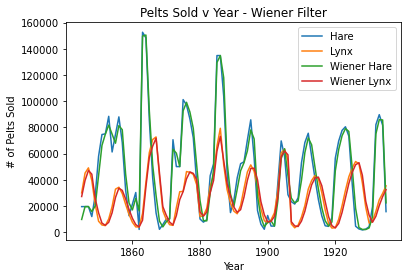

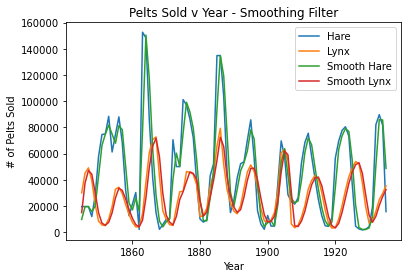

In [6]:
pelts = pd.read_csv("pelt_data.csv")

n = 2
w_hare = wiener(pelts.Hare, mysize=n)
w_lynx = wiener(pelts.Lynx, mysize=n)

kernel = np.ones(n)/n
s_hare = np.convolve(pelts.Hare, kernel, 'same')
s_lynx = np.convolve(pelts.Lynx, kernel, 'same')

#wiener
plt.plot(pelts.Year, pelts.Hare, label = 'Hare')
plt.plot(pelts.Year, pelts.Lynx, label = 'Lynx')
plt.plot(pelts.Year, w_hare, label = 'Wiener Hare')
plt.plot(pelts.Year, w_lynx, label = 'Wiener Lynx')
plt.xlabel('Year')
plt.ylabel('# of Pelts Sold')
plt.title('Pelts Sold v Year - Wiener Filter')
plt.legend()
plt.show()

#smoothing
plt.plot(pelts.Year, pelts.Hare, label = 'Hare')
plt.plot(pelts.Year, pelts.Lynx, label = 'Lynx')
plt.plot(pelts.Year, s_hare, label = 'Smooth Hare')
plt.plot(pelts.Year, s_lynx, label = 'Smooth Lynx')
plt.xlabel('Year')
plt.ylabel('# of Pelts Sold')
plt.title('Pelts Sold v Year - Smoothing Filter')
plt.legend()
plt.show()

A window size of 2 seems to fit the periodicity of the data best. A larger n (for example n=25) seems to obliterate the periodicity of the data as the lines are more flat/do not follow the data as well. Also, the smoothing filter looks more flat, so its periodicity is eliminated even more at higher n's compared to the wiener filter. A smaller n of 1 does not work.

### EEG Data
I am using the same two filters again (smoothing and Wiener) to explore denoising the EEG data

In [7]:
eeg = pd.read_csv("extrait_wSleepPage01.csv", decimal=",")

#only using the first 4096 rows
eeg = eeg.iloc[0:2**12]

#combining mintues and seconds into one 'time' variable
eeg['time'] = (eeg.MM*60) + eeg.SS
eeg.head()

,Date,HH,MM,SS,EOG Left,EEG C3-A1,EEG O1-A1,EEG C4-A1,EEG O2-A1,time
0,08/03/2016,1,27,22.000,7.812500e-01,5.566406,-12.402344,0.976562,13.769531,1642.000
1,08/03/2016,1,27,22.005,1.953125e+00,4.785156,-11.230469,-0.097656,17.089844,1642.005
2,08/03/2016,1,27,22.010,-1.670000e-14,4.296875,-11.230469,0.976562,17.968750,1642.010
3,08/03/2016,1,27,22.015,7.812500e-01,4.785156,-12.011719,6.347656,20.117188,1642.015
4,08/03/2016,1,27,22.020,2.929688e-01,4.101562,-13.183594,8.105469,17.382812,1642.020


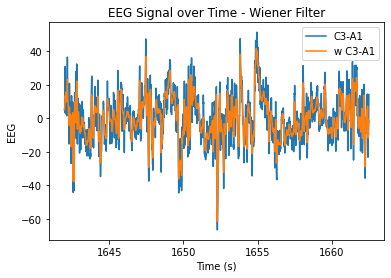

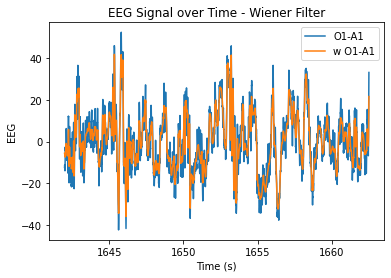

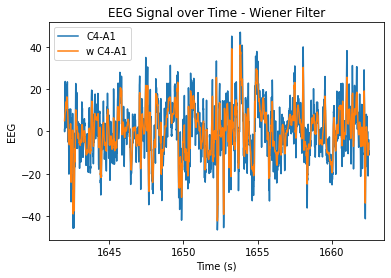

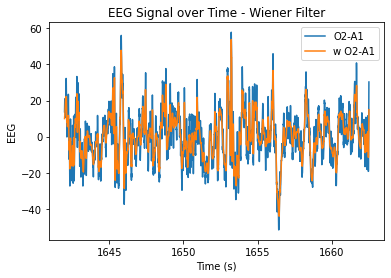

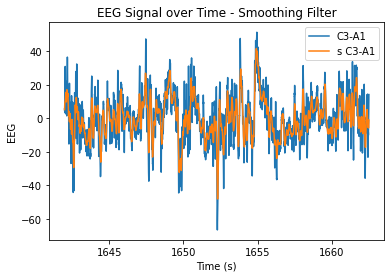

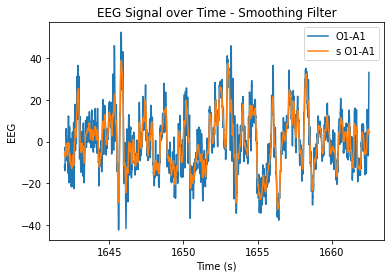

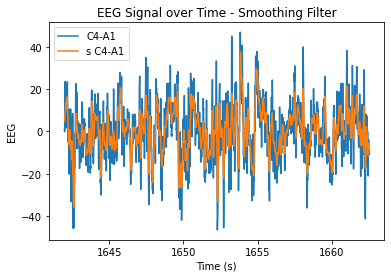

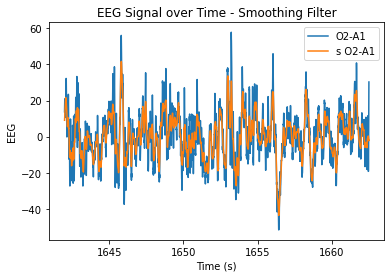

In [8]:
n = 20
w_c3a1 = wiener(eeg.iloc[:,5], mysize=n)
w_01a1 = wiener(eeg.iloc[:,6], mysize=n)
w_c4a1 = wiener(eeg.iloc[:,7], mysize=n)
w_o2a1 = wiener(eeg.iloc[:,8], mysize=n)

kernel = np.ones(n)/n
s_c3a1 = np.convolve(eeg.iloc[:,5], kernel, 'same')
s_01a1 = np.convolve(eeg.iloc[:,6], kernel, 'same')
s_c4a1 = np.convolve(eeg.iloc[:,7], kernel, 'same')
s_o2a1 = np.convolve(eeg.iloc[:,8], kernel, 'same')

#wiener
plt.plot(eeg.time, eeg.iloc[:,5], label = 'C3-A1')
plt.plot(eeg.time, w_c3a1, label = 'w C3-A1')
plt.xlabel('Time (s)')
plt.ylabel('EEG')
plt.title('EEG Signal over Time - Wiener Filter')
plt.legend()
plt.show()

plt.plot(eeg.time, eeg.iloc[:,6], label = 'O1-A1')
plt.plot(eeg.time, w_01a1, label = 'w O1-A1')
plt.xlabel('Time (s)')
plt.ylabel('EEG')
plt.title('EEG Signal over Time - Wiener Filter')
plt.legend()
plt.show()

plt.plot(eeg.time, eeg.iloc[:,7], label = 'C4-A1')
plt.plot(eeg.time, w_c4a1, label = 'w C4-A1')
plt.xlabel('Time (s)')
plt.ylabel('EEG')
plt.title('EEG Signal over Time - Wiener Filter')
plt.legend()
plt.show()

plt.plot(eeg.time, eeg.iloc[:,8], label = 'O2-A1')
plt.plot(eeg.time, w_o2a1, label = 'w O2-A1')
plt.xlabel('Time (s)')
plt.ylabel('EEG')
plt.title('EEG Signal over Time - Wiener Filter')
plt.legend()
plt.show()


#smoothing
plt.plot(eeg.time, eeg.iloc[:,5], label = 'C3-A1')
plt.plot(eeg.time, s_c3a1, label = 's C3-A1')
plt.xlabel('Time (s)')
plt.ylabel('EEG')
plt.title('EEG Signal over Time - Smoothing Filter')
plt.legend()
plt.show()

plt.plot(eeg.time, eeg.iloc[:,6], label = 'O1-A1')
plt.plot(eeg.time, s_01a1, label = 's O1-A1')
plt.xlabel('Time (s)')
plt.ylabel('EEG')
plt.title('EEG Signal over Time - Smoothing Filter')
plt.legend()
plt.show()

plt.plot(eeg.time, eeg.iloc[:,7], label = 'C4-A1')
plt.plot(eeg.time, s_c4a1, label = 's C4-A1')
plt.xlabel('Time (s)')
plt.ylabel('EEG')
plt.title('EEG Signal over Time - Smoothing Filter')
plt.legend()
plt.show()

plt.plot(eeg.time, eeg.iloc[:,8], label = 'O2-A1')
plt.plot(eeg.time, s_o2a1, label = 's O2-A1')
plt.xlabel('Time (s)')
plt.ylabel('EEG')
plt.title('EEG Signal over Time - Smoothing Filter')
plt.legend()
plt.show()

At n=20, the level of smoothing seems helpful, but it still allows for the essential periodicity of the data to be seen. At very high n values, the wiener filter appears to maintain the periodicity of the data a lot better in comparison to the smoothing filter (smooths it out too much/more flat). At lower n values, the data is just not very smooth and resembles the original very closely. 

### Creating a band pass filter

In [9]:
def bpf(data, k):
    if k > 0.5*len(data):
        print('k too big')
    else:
        f_vec = np.ones(len(data))
        center = int(len(data)/2 + 1)
        left = center - ((2*k)/2)
        right = center + ((2*k)/2)
        f_vec[int(left):int(right)] = 0
        ft = np.fft.fft(data)
        vec_multiplied = ft*f_vec
    return np.fft.ifft(vec_multiplied)

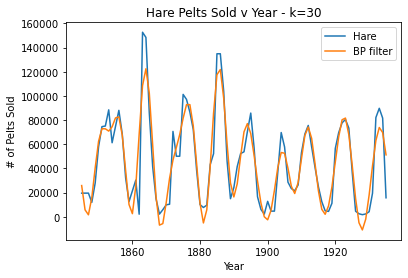

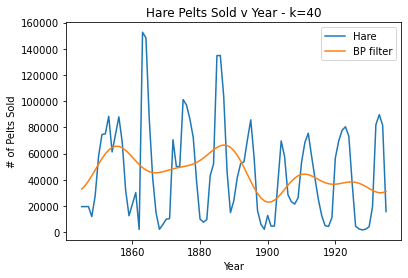

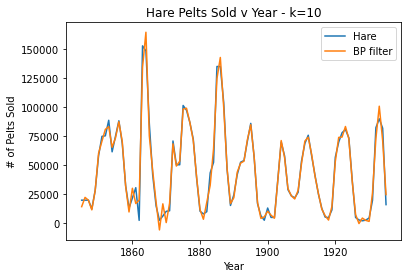

In [10]:
#k=30, good
plt.plot(pelts.Year, pelts.Hare, label = 'Hare')
bphare = bpf(pelts.Hare, 30)
plt.plot(pelts.Year, bphare, label = 'BP filter')
plt.xlabel('Year')
plt.ylabel('# of Pelts Sold')
plt.title('Hare Pelts Sold v Year - k=30')
plt.legend()
plt.show()

#k=40, too smooth
plt.plot(pelts.Year, pelts.Hare, label = 'Hare')
bphare = bpf(pelts.Hare, 40)
plt.plot(pelts.Year, bphare, label = 'BP filter')
plt.xlabel('Year')
plt.ylabel('# of Pelts Sold')
plt.title('Hare Pelts Sold v Year - k=40')
plt.legend()
plt.show()

#k=10, over fit 
plt.plot(pelts.Year, pelts.Hare, label = 'Hare')
bphare = bpf(pelts.Hare, 10)
plt.plot(pelts.Year, bphare, label = 'BP filter')
plt.xlabel('Year')
plt.ylabel('# of Pelts Sold')
plt.title('Hare Pelts Sold v Year - k=10')
plt.legend()
plt.show()

For the Hare data, when k = 30 the band pass filter provides a nice smooth fit for the data without losing the periodicity. When k is very large (40), the filter oversmooths and a lot of the periodicity is lost. Then, when k is very small (10), the data is overfit/periodicity or spikes are created where there shouldn't be any. 